 Анализ развлекательного приложения.

Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.



# Шаг 1. Подготовка данных к анализу


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import seaborn as sns
from datetime import date, datetime, time, timedelta


In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


1) Названия колонок надо привести в порядок: нижний регистр, нижнее подчеркивание 

2) Во всех трех таблицах содеражтся даты, которые надо привести к формату дат

3) Проверить на дубликаты

Пропусков нет. 

In [4]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [5]:
visits = visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})

orders = orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'})

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [7]:
visits.duplicated().sum()

0

In [8]:
orders.duplicated().sum()

0

In [9]:
costs.duplicated().sum()

0

Дубликатов нет.

In [10]:
visits.sample()


,user_id,region,device,channel,session_start,session_end
19908,806902775821,United States,Android,FaceBoom,2019-05-21 10:01:59,2019-05-21 10:28:54


In [11]:
orders.sample()


,user_id,event_dt,revenue
290,901485994748,2019-05-08 06:45:10,4.99


In [12]:
costs.sample()


,dt,channel,costs
520,2019-10-08,RocketSuperAds,7.475


Данные готовы. Названия колонок приведены к нижнему регистру, исправлены названия некоторых колонок в таблицах visits и orders. Дубликатов не найдено. Можно приступать к анализу. 

# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

(Разрешается использовать функции, с которыми вы познакомились в теоретических уроках, поэтому взяла из теории нужные функции)

In [13]:
# функция для создания пользовательских профилей
def get_profiles(visits, orders, ad_costs=[]):

    
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles




In [14]:


def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    
    dimensions = ['payer'] + dimensions

    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

   
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    
    return result_raw, result_grouped, result_in_time

In [15]:

# функция для расчёта конверсии
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
    
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    
    return result_raw, result_grouped, result_in_time

In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Задачи:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [21]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [22]:
profiles['dt'].min()


datetime.date(2019, 5, 1)

In [23]:
profiles['dt'].max()

datetime.date(2019, 10, 27)

В описании проекта сказано о том, что данные содержат информацию о пользователях, зарегистрировавшихся в период с 2019-05-01 по 2019-10-27. Что мы и наблюдаем, найдя минимальную и максимальную дату.

In [24]:
 profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)


,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


Больше всего пользоваетелей из США. Второе место делят Англия и Франция. С небольшим отставанием Германия следует за ними.

In [25]:
 profiles.groupby('region').agg({'payer': 'mean'}).sort_values(by='payer', ascending=False)

,payer
region,
United States,0.069019
Germany,0.041119
UK,0.039829
France,0.037994


Что касается платящих пользователей, на первом месте США. Следом идет Германия. Затем Англия и Франция. 

In [26]:
 profiles.groupby('device').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)

,user_id
device,
iPhone,54479
Android,35032
PC,30455
Mac,30042


Большее количество пользователей пользуются iPhone, на втором месте расоположились владельцы Android. Затем с небольшой разницей идут пользователи PC и Mac. Число мобильных пользователей преобладает. 

In [27]:
 profiles.groupby('device').agg({'payer': 'mean'}).sort_values(by='payer', ascending=False)

,payer
device,
Mac,0.063644
iPhone,0.062079
Android,0.058518
PC,0.050468


С платящими пользователями ситуация немного иная. Пользователей Mac и iPhone больше чем владельцев Android. Меньше всего платящих с PC. 

In [28]:
profiles.groupby('channel').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)

,user_id
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


С большим открывом доля привлеченых приходится на органический трафик. За ним идут FaceBoom и TipTop.

In [29]:
 profiles.groupby('channel').agg({'payer': 'mean'}).sort_values(by='payer', ascending=False)

,payer
channel,
FaceBoom,0.122049
AdNonSense,0.113402
lambdaMediaAds,0.104700
TipTop,0.096007
RocketSuperAds,0.079137
WahooNetBanner,0.052964
YRabbit,0.038265
MediaTornado,0.035747
LeapBob,0.030633


Тут ситуация кардинально поменялась. Большую часть платящих составляют пользователи, привлеченные по каналам FaceBoom, AdNonSense и lambdaMediaAds. 

Опираясь на проведенный анализ, можно сделать выводы: 

    - Больше всего пользователей из США. Второе место делят Англия и Франция. Однако среди платящих на первом месте США. Следом идет Германия. Затем Англия и Франция. 
    - Среди устройств на первом месте iPhone, на втором месте Android. Затем с небольшой разницей идут пользователи PC и Mac. Число мобильных пользователей преобладает. 
    - Что кассается платящих пользователей, пользователей Mac и iPhone больше чем владельцев Android. Меньше всего платящих с PC. 
    - С большим открывом доля привлеченых приходится на органический трафик. За ним идут FaceBoom и TipTop.
    - Большую часть платящих составлят пользователи, привлеченные по каналам FaceBoom, AdNonSense и lambdaMediaAds. 

# Шаг 4. Маркетинг

Задачи:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [30]:
costs

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


In [31]:
print('Всего потратили:', costs['costs'].sum().round(2))

Всего потратили: 105497.3


In [32]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by = 'costs', ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Большое количество средств уходит на канал TipTop. На втором месте FaceBoom, на него тратится почти в два раза меньше, однако по сравнению с остальными источниками все равно много.

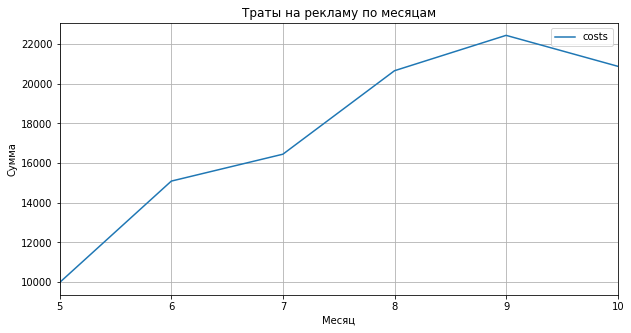

In [33]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs.groupby('month').agg({'costs': 'sum'}).plot(grid=True, figsize=(10, 5))
plt.ylabel('Сумма')
plt.xlabel('Месяц')
plt.title('Траты на рекламу по месяцам')
plt.show()

Расходы на рекламу неуклонно росли с мая по сентябрь. К октябрю сумма стала уменьшаться.

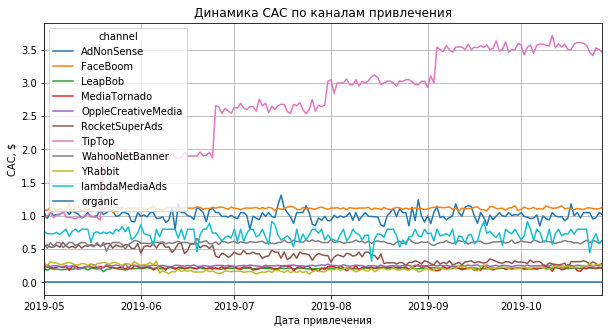

In [34]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Больше всего потратили на TipTop. Наблюдается рост расходов на него с течением времени. Траты на другие источники относительно стабильны. На втором и третьем месте FaceBoom и AdNonSense.

In [35]:
cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
).sort_values(by='cac', ascending=False)

cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Самая высокая средняя стоимость у TipTop. На втором и третьем месте FaceBoom и AdNonSense.

In [36]:
# исключаем органический трафик 
print('В среднем привлечение одного пользователя:', profiles.query('channel != "organic"')['acquisition_cost'].mean())

В среднем привлечение одного пользователя: 1.1274813239427588


 Всего потратили на рекламу 105497.3. Из них на TipTop потратили 54751.30, а на FaceBoom 32445.60. На остальные каналы траты значительно ниже.
 
Больше всего денег потратили на TipTop. Также наблюдается рост расходов на него с течением времени. Траты на другие источники относительно стабильны. На втором и третьем месте FaceBoom и AdNonSense.
 
 Самая высокая средняя стоимость у TipTop. На втором и третьем месте FaceBoom и AdNonSense.
 
 В среднем привлечение одного пользователя: 1.127.
 

# Шаг 5. Окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Описать возможные причины обнаруженных проблем и сформировать рекомендации для рекламного отдела. Данные 1-го ноября 2019 года и в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

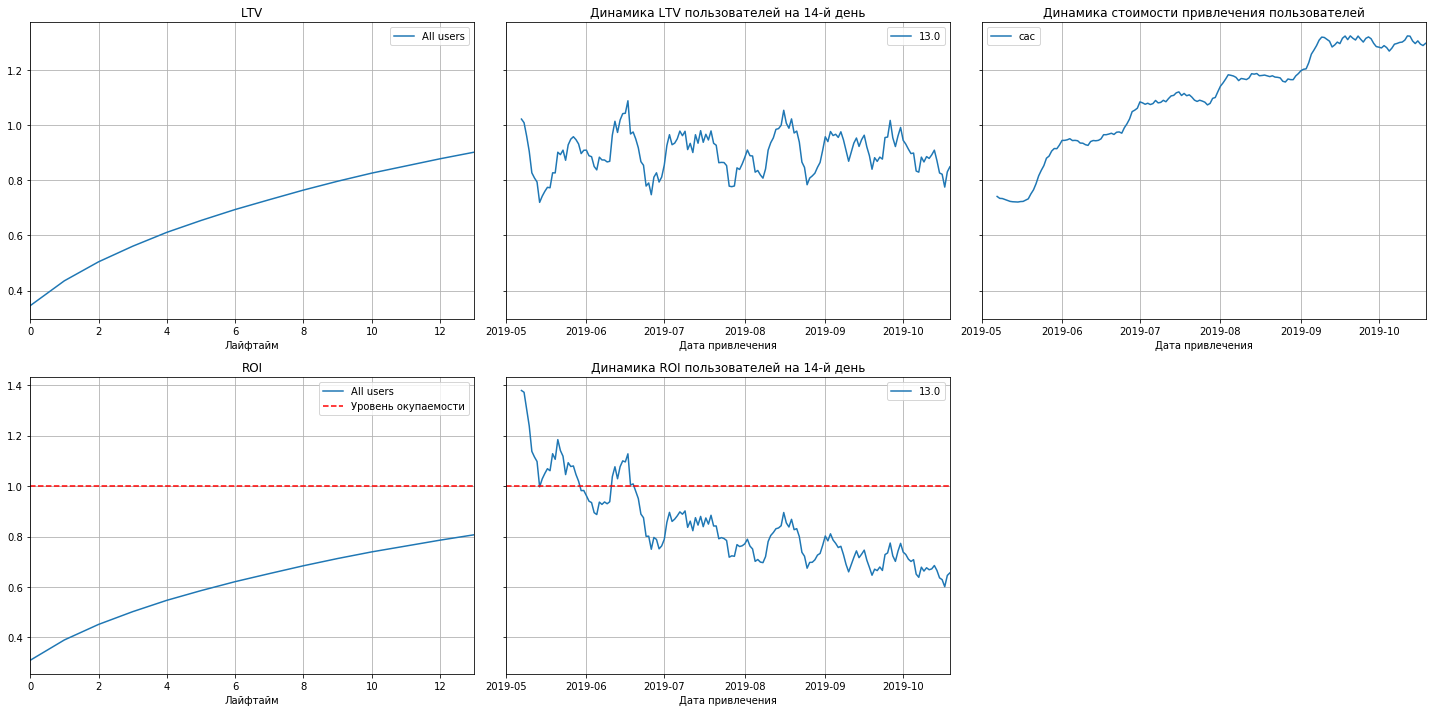

In [38]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Из общей окупаемости мы видим:

    ROI к концу второй недели около 80%. Реклама не окупается.
    CAC не стабилен. Наблюдается увеличение рекламного бюджета.
    LTV достаточно стабилен.
    По динамике ROI видим, что он падает. После июня уже стал нижне уровня окупаемости.



### Проанализируйте окупаемость рекламы с разбивкой по устройствам

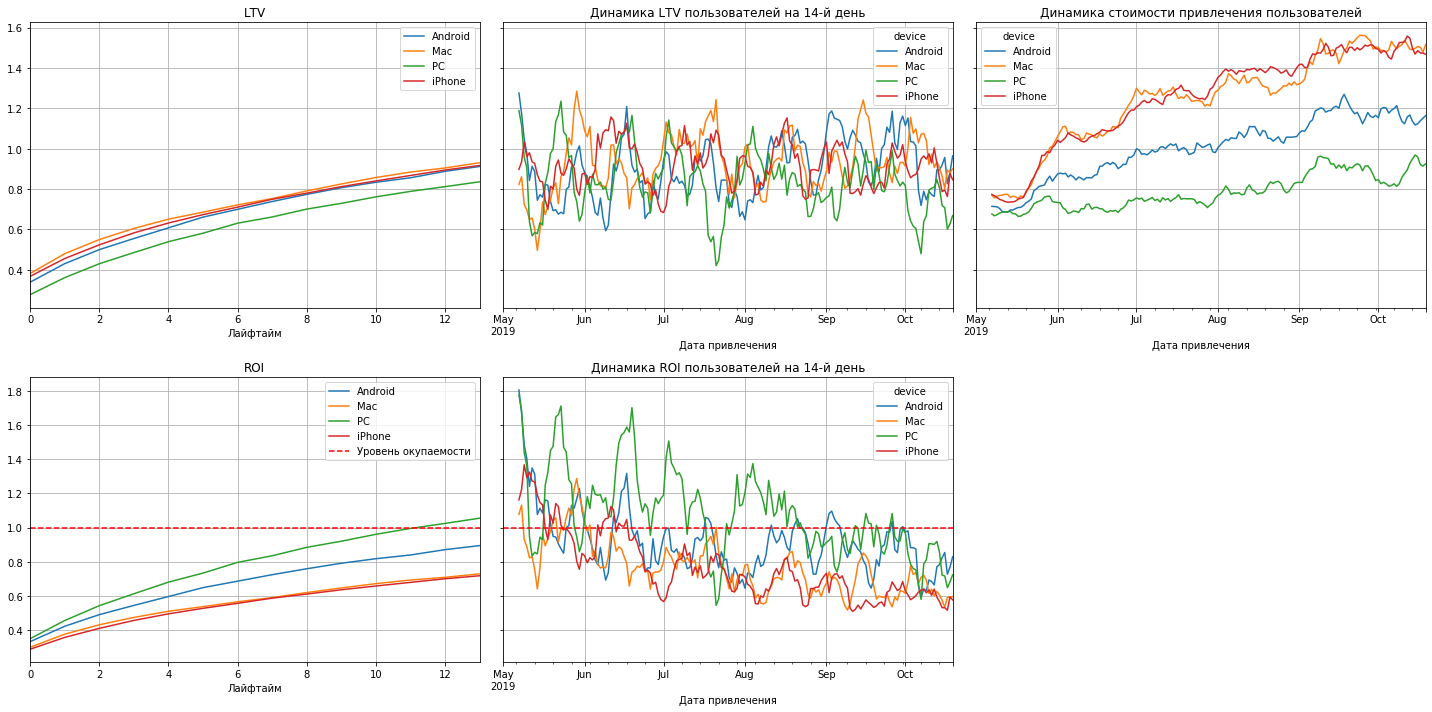

In [39]:
dimensions = ['device']
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Из графиков разбивки по устройствам:

    Пользователи Android, iPhone и Mac не окупаются, а вот владельцы РС — да.
    Пи динамике ROI видим, что у пользователей РС довольно резко упала окупаемость. В целом, с течением времени окупаемость упала для всех.
    Стоит также обратить внимание на Android, в начале осени ситуация стала получше, но потом снова упадок.
    При это стоимость привлечения неуклонно растет. В частности, для iPhone и Mac.
    
    

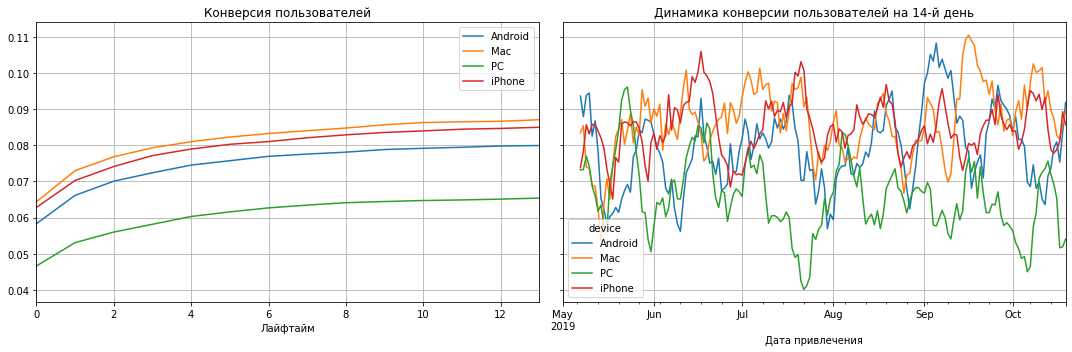

In [40]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия относительно стабильна. Построим графики удержания.

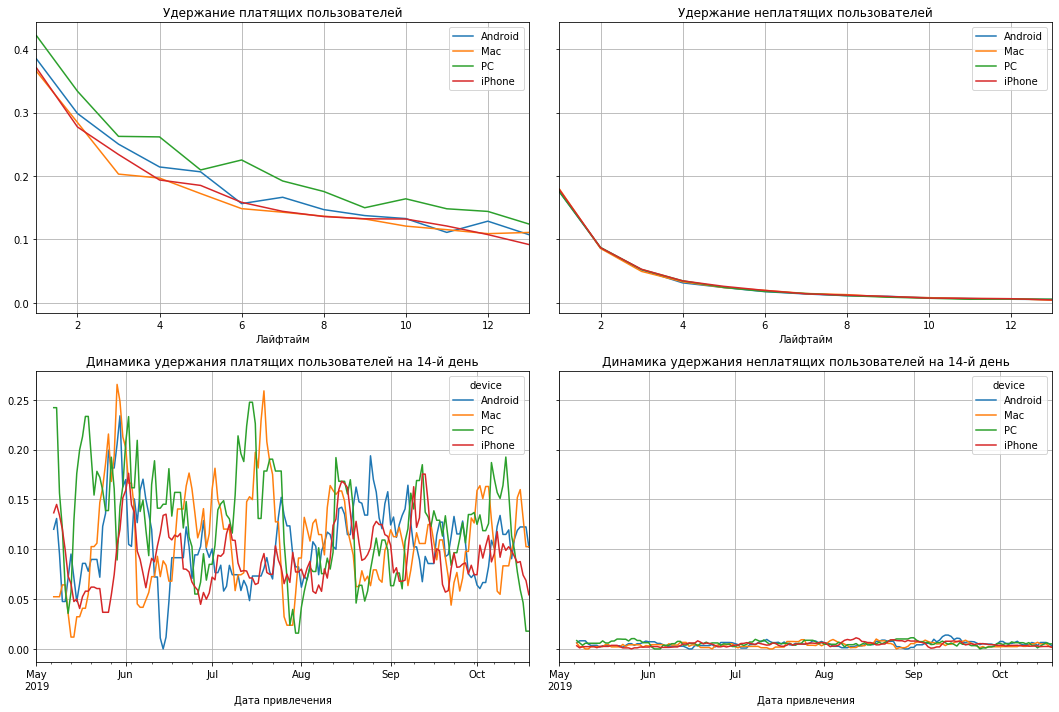

In [41]:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Судя по графикам удержания, нет никаких выделяющихся устройств. 

### Проанализируйте окупаемость рекламы с разбивкой по странам

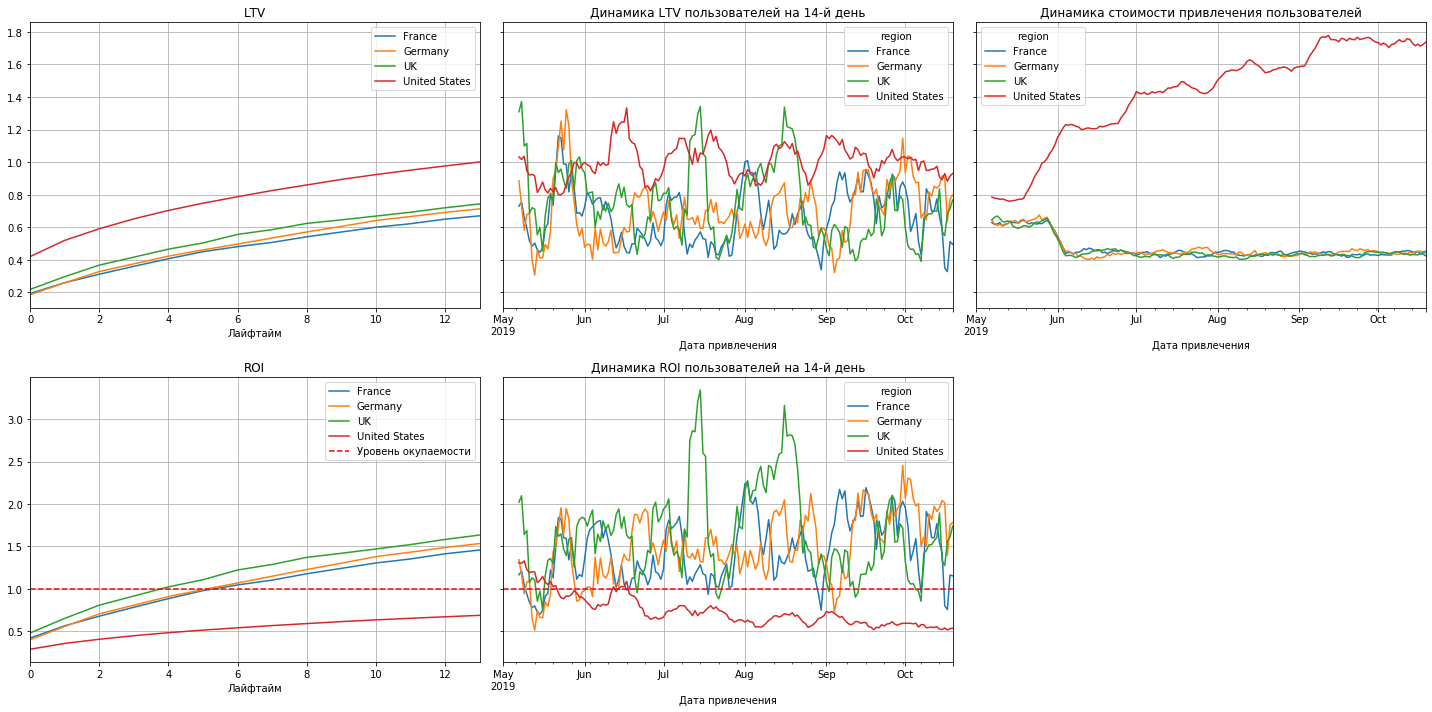

In [42]:
dimensions = ['region']
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

Из графиков разбивки по странам:

    Стоимость привлечения в США выше других и стремительно растет.
    Однако на фоне роста стоимость реклама в США не окупается. 
    LTV стабилен.
    Лучшая окупаемсть при небольшой стоимости у Англии.

Продолжим анализ по странам, так как тут есть зацепка.
    

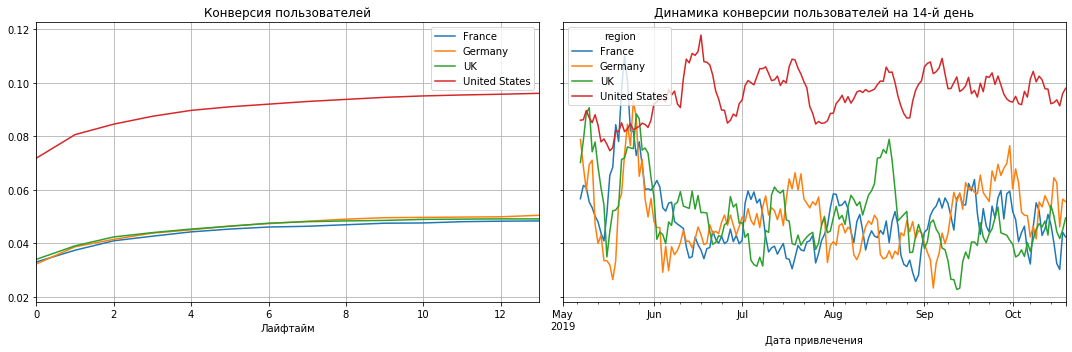

In [43]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

По графику видно, что конверсия в Англии стабильно хорошая. Касательно этого показателя, проблем нет. 
Конверсия других стран стабильна, хоть и ниже Англии.

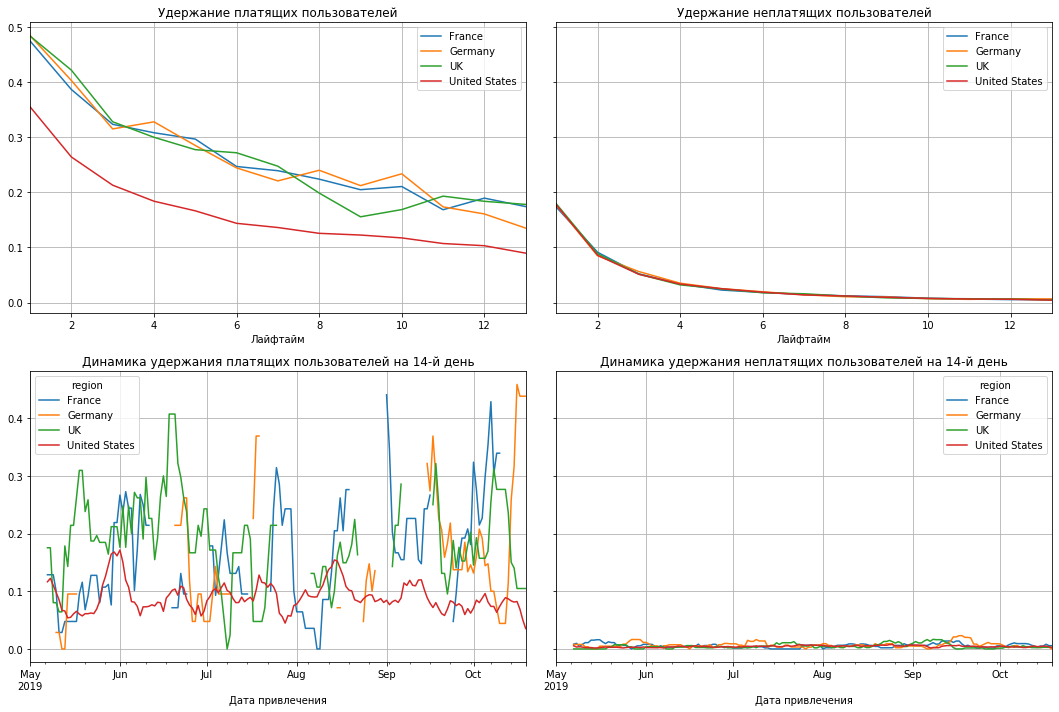

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Наблюдается проблема в удержании платящих пользователей из США. Оно ниже, чем у других стран.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

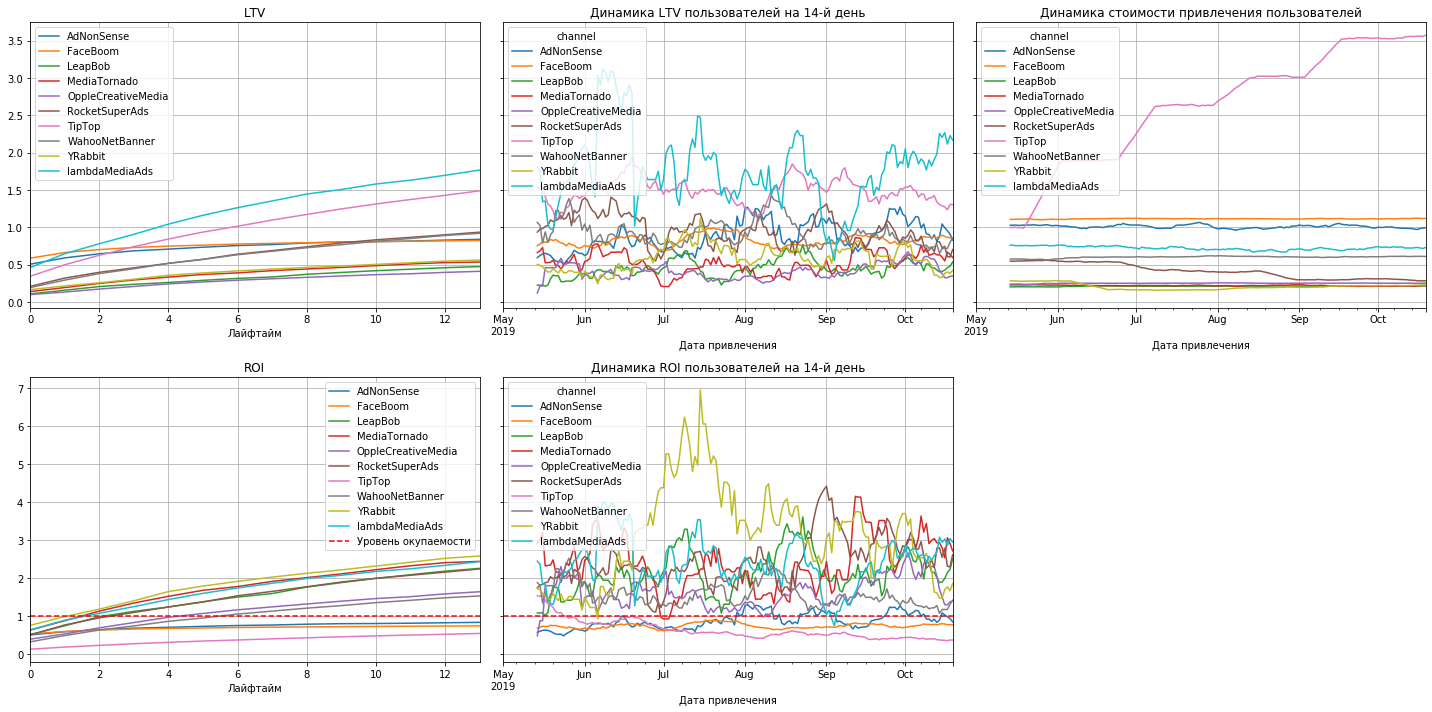

In [45]:
dimensions = ['channel']
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

Из графиков разбивки по каналам:

    Стоимость привлечения по каналу TipTop выше других и стремительно растет.
    Однако при этом TipTop абсолютно не окупается. 
    Не окупаются также AdNonSense, FaceBoom.
    LTV стабилен.
    Летом наблюдался скачок ROI на 14-ый день у YRabbit при такой же стоимости. 

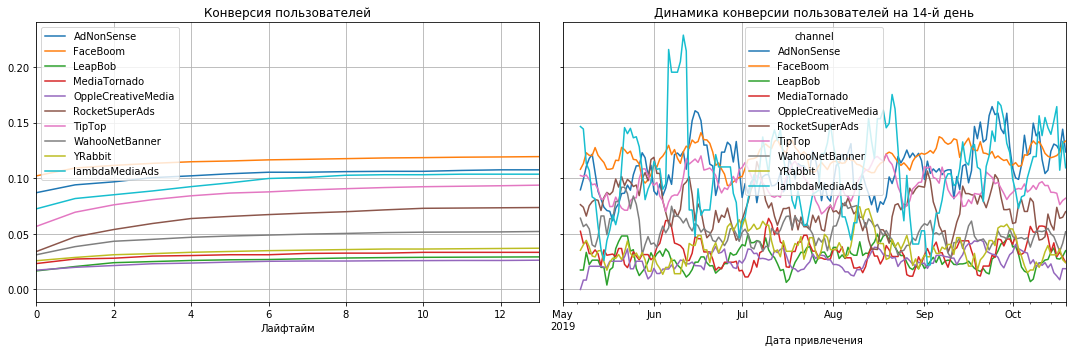

In [46]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия стабильна.

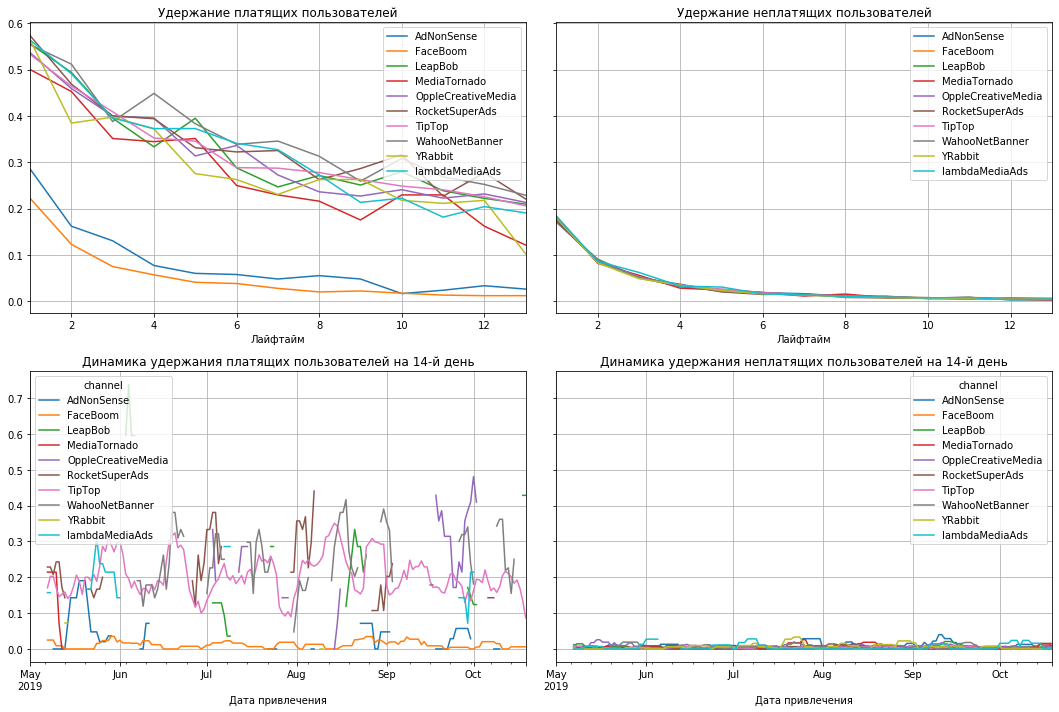

In [47]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Из графиков видим, что хуже всего удерживаются пользователи из FaceBoom и AdNonSense.

# Шаг 6. Выводы


Анализа показал следующие результаты:

- Больше всего пользователей из США. Второе место делят Англия и Франция. 
- Cреди платящих на первом месте США. Следом идет Германия. Затем Англия и Франция. 
- Среди устройств на первом месте iPhone, на втором месте Android. Затем с небольшой разницей идут пользователи PC и Mac.  - - Число мобильных пользователей преобладает. 
- Что касается платящих пользователей, пользователей Mac и iPhone больше чем владельцев Android. Меньше всего платящих с PC. 
- С большим открывом доля привлеченых приходится на органический трафик. За ним идут FaceBoom и TipTop.
- Большую часть платящих составлят пользователи, привлеченные по каналам FaceBoom, AdNonSense и lambdaMediaAds. 
- Больше всего денег потратили на канал TipTop. Наблюдается рост расходов на него с течением времени. 
- Траты на другие источники относительно стабильны. На втором и третьем месте по тратам FaceBoom и AdNonSense.
- Самая высокая средняя стоимость привлечения у TipTop. На втором и третьем месте FaceBoom и AdNonSense.
  
Выводы по окупаемости:

- ROI к концу второй недели около 80%. Реклама не окупается.
- CAC не стабилен. Наблюдается увеличение рекламного бюджета.
- LTV достаточно стабилен.
- По динамике ROI видим, что он падает. После июня уже стал нижне уровня окупаемости.
- Пользователи Android, iPhone и Mac не окупаются, а вот владельцы РС да.
- У пользователей РС довольно резко упала окупаемость. В целом, с течением времени окупаемость упала для всех.
- При это стоимость привлечения неуклонно растет. В частности, для iPhone и Mac.
- Стоимость привлечения в США выше других и стремительно растет.
- Однако на фоне роста стоимость реклама в США не окупается. 
- Лучшая окупаемость при небольшой стоимости у Англии.
- Наблюдается проблема в удержании платящих пользователей из США. 
- Стоимость привлечения по каналу TipTop выше других и стремительно растет.
- Однако при этом TipTop абсолютно не окупается. 
- Не окупаются также AdNonSense, FaceBoom.
- LTV стабилен.
- Летом наблюдался скачок ROI на 14-ый день у YRabbit при такой же стоимости. 
- Из графиков видим, что хуже всего удерживаются пользователи из FaceBoom и AdNonSense.


Заключительные выводы и рекомендации: 
- Больше всего пользователей из США, на рекламу в США тратится больше всего денег, и со временем эта цифра только растет, однако реклама в США не окупается. Надо проанализировать отдельно рынок США, какие устройства там популярны, какие каналы приносят больше всего пользователей. Кажется, проблема с США заключается именно в рекламе. В США также есть проблема с удержанием пользователей, возможно, техническая ошибка. Нужно проанализировать дополнительные данные об ошибках. 
- Главная проблема каналов привлечения - это TipTop. При высоких тратах никакой окупаемости нет. Возможно, стоит совсем от него отказаться. 
- Подобная ситуация и с FaceBoom. Стоит решить, вкладывать ли дальше в него деньги.
- Стоит пересмотреть использование источника AdNonSense.
- Стоит сделать упор на мобильных пользователей. Их число преобладает. Однако окупаются пользователи РС, чья доля платящих пользователей также ниже.
- WahooNetBanner, OppleCreativeMedia и LeapBob находятся в середине по числу привлеченных пользователей, при этом они стабильно окупаются и показывают неплохие результаты при небольших затратах. Можно подумать о вложении больше средст в эти каналы, если есть возможность привлечь оттуда большее количество. 
- На канал YRabbit потратили меньше всего средств, однако он принес не самое меньшее количество пользователей. Можно рассмотреть его, как вариант. 
